<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Detrended_Fluctuation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from collections import deque

# =====================================
# 1️⃣  Gerador de dados sintéticos tipo EDP/REN
# =====================================

def generate_synthetic_price(n=2000, hurst=0.6, drift=0.0002, vol=0.01):
    dt = 1
    noise = np.random.normal(0, 1, n)
    fbm = np.cumsum(noise)

    # Escalamento aproximado para simular persistência
    fbm = fbm * (np.arange(1, n+1) ** (hurst - 0.5))

    price = 10 + np.cumsum(drift + vol * fbm / np.std(fbm))
    return price

# Série tipo EDP (mais estável)
edp_price = generate_synthetic_price(hurst=0.55)

# Série tipo REN (mais persistente)
ren_price = generate_synthetic_price(hurst=0.65)


In [2]:
def dfa(series, min_window=10, max_window=200):
    series = np.array(series)
    series -= np.mean(series)

    y = np.cumsum(series)

    scales = np.logspace(np.log10(min_window),
                         np.log10(max_window),
                         num=20).astype(int)

    fluct = []

    for s in scales:
        segments = len(y) // s
        rms = []

        for i in range(segments):
            segment = y[i*s:(i+1)*s]
            x = np.arange(s)
            coef = np.polyfit(x, segment, 1)
            trend = np.polyval(coef, x)
            rms.append(np.sqrt(np.mean((segment - trend)**2)))

        fluct.append(np.mean(rms))

    slope, _, _, _, _ = stats.linregress(np.log(scales), np.log(fluct))
    return slope


In [3]:
window_size = 500
hurst_edp = []
hurst_ren = []

for i in range(window_size, len(edp_price)):
    hurst_edp.append(dfa(edp_price[i-window_size:i]))
    hurst_ren.append(dfa(ren_price[i-window_size:i]))


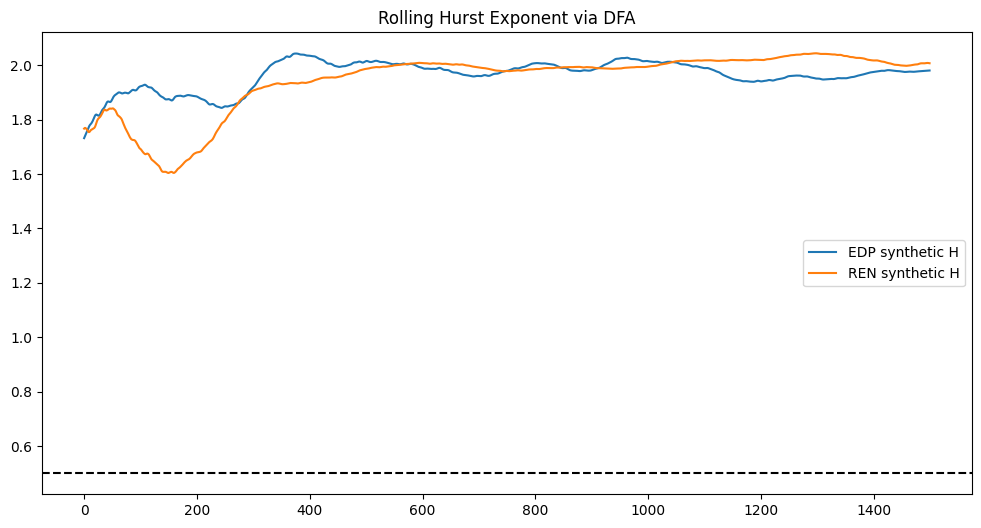

In [4]:
plt.figure(figsize=(12,6))
plt.plot(hurst_edp, label="EDP synthetic H")
plt.plot(hurst_ren, label="REN synthetic H")
plt.axhline(0.5, linestyle="--", color="black")
plt.legend()
plt.title("Rolling Hurst Exponent via DFA")
plt.show()
